In [25]:
import pandas as pd
import numpy as np
import openpyxl
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
from collections import Counter
from imblearn.over_sampling import SMOTENC

In [26]:
# Data Setup
trainData = pd.read_csv('./dataset/cases_2021_train.csv')
testData = pd.read_csv('./dataset/cases_2021_test.csv')
location = pd.read_csv('./dataset/location_2021.csv')
#https://github.com/samayo/country-json/blob/master/src/country-by-continent.json
countryMap = pd.read_json('./dataset/countryMap.json')


In [27]:
# Globals
fullSet = pd.concat([trainData,testData], ignore_index=True)
fullSet = pd.merge(fullSet, countryMap, on='country', how='left')
countrySet = fullSet.groupby("country")
fullSet = fullSet.groupby("continent")
results = {}
# This is a pre-config for the world map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

C:\Users\Long\AppData\Local\Temp\ipykernel_16052\4008181475.py:8: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


In [28]:
# HELPERS

# Helper function, this is what is counting and calculating data that is currently present
def parsePercentages(group):
    counts = {}
    for column in group.columns:
        counts[column] = group[column].count()
    percentages = {field: (count /  len(group)) * 100 for field, count in counts.items()}
    total_percent = sum(percentages.values()) / 11
    return counts, percentages, total_percent

# Helper function to create heat maps, if you want to change something about the heat maps do it here
def createHeatMap(world, column, title, filename):
    fig, ax = plt.subplots()
    world.plot(column=column, cmap='YlOrRd', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
    ax.axis('off')
    ax.set_title(title, fontdict={'fontsize': '18', 'fontweight' : '3'})
    plt.show()


In [29]:
# Continent Logic
for country, group in fullSet:
    counts, percentages, total_percent = parsePercentages(group)
    results[country] = {
        "DataSize": len(group), # total data size per country
        "counts":counts, # counts data that exists vs what does not exist
        "percentages":percentages, # calculates percentage of data that is avaialable for each category
        "overall data": total_percent # calculates an overall "percent" of data that is present
    }

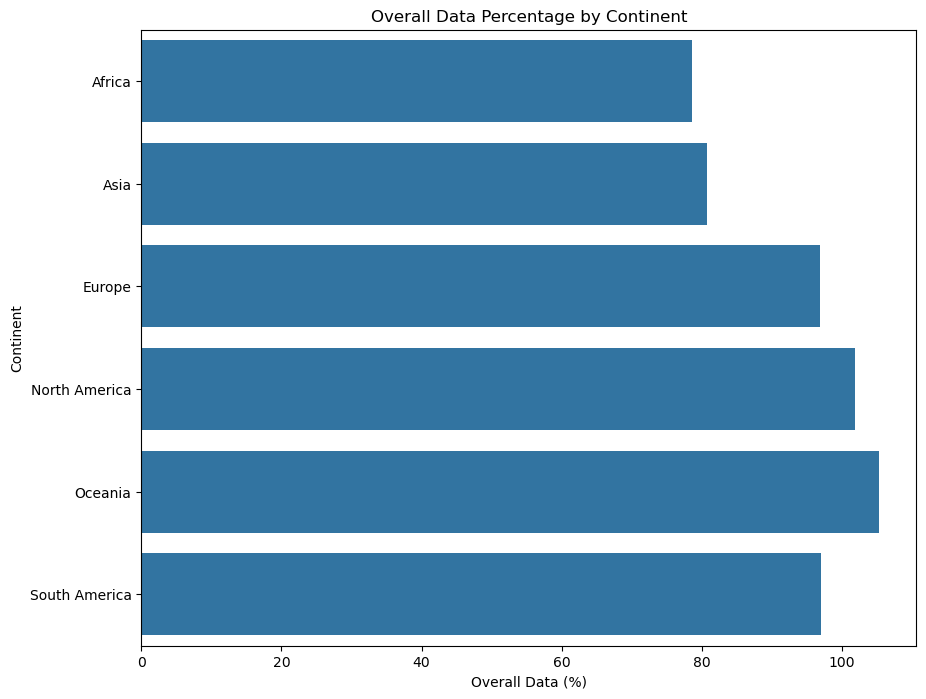

In [30]:
# Convert to data frame to work with data properly, need to use Transpose to set country as col. 
barResults = pd.DataFrame(results).T
# For bar plot of continents
plt.figure(figsize=(10, 8))
sns.barplot(x=barResults['overall data'], y=barResults.index)
plt.xlabel('Overall Data (%)')
plt.ylabel('Continent')
plt.title('Overall Data Percentage by Continent')
plt.show()

In [31]:
for country, group in countrySet:
    counts, percentages, total_percent = parsePercentages(group)
    country_index = world.index[world['name'] == country].tolist()
    if country_index:
        world.at[country_index[0], 'overallPercent'] = total_percent
        world.at[country_index[0], 'agePercent'] = percentages['age']
        world.at[country_index[0], 'sexPercent'] = percentages['sex']
        world.at[country_index[0], 'outcome'] = percentages['outcome']
# Lots of countries missing, need to fill them with something otherwise they just dont appear on maps
world['overallPercent'].fillna(0, inplace=True)
world['agePercent'].fillna(0, inplace=True)
world['sexPercent'].fillna(0, inplace=True)
world['outcome'].fillna(0, inplace=True)

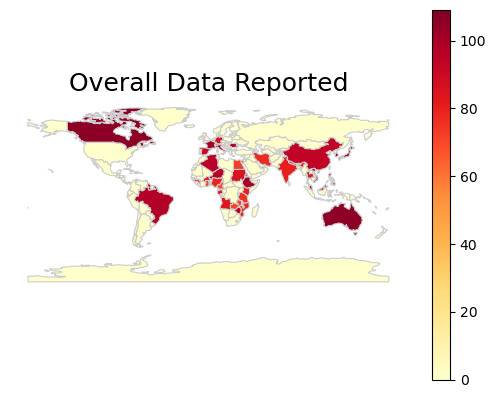

In [32]:
# Heatmaps
createHeatMap(world, 'overallPercent', 'Overall Data Reported', 'Overall.svg')

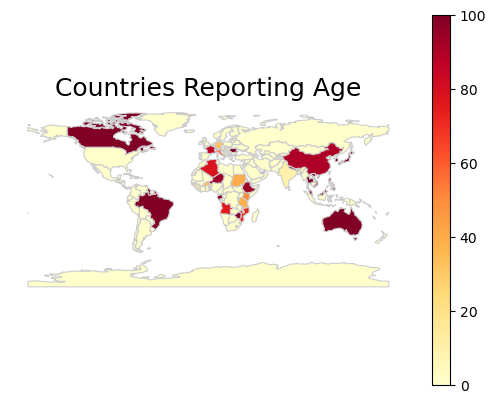

In [33]:
createHeatMap(world, 'agePercent', 'Countries Reporting Age', 'Countries.svg')


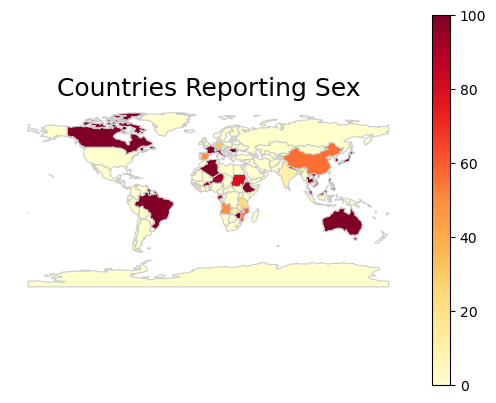

In [34]:
createHeatMap(world, 'sexPercent', 'Countries Reporting Sex', 'Sex.svg')

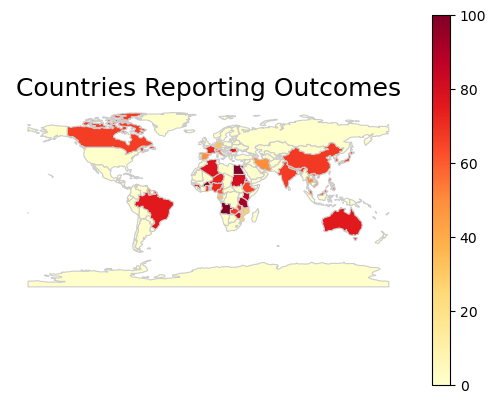

In [35]:
createHeatMap(world, 'outcome', 'Countries Reporting Outcomes', 'Outcome.svg')

In [36]:
# EXCEL - DF CSV CONVERSION


trainfile = pd.read_excel ('dataset/cases_2021_train_processed_2.xlsx') 
testfile = pd.read_excel ('dataset/cases_2021_test_processed_unlabelled_2.xlsx') 
# Write the dataframe object into csv file 
trainfile.to_csv ('dataset/Train.csv',  
                  index = None, 
                  header=True)
testfile.to_csv ('dataset/Test.csv',  
                  index = None, 
                  header=True) 

In [37]:
# TASK 4: FEATURE MAPPING AND SAVE MAPPED SET

# read csv file and convert into a dataframe object 
trainData = pd.DataFrame(pd.read_csv('dataset/Train.csv')) 
testData = pd.DataFrame(pd.read_csv('dataset/Test.csv'))
# map function
def mapFeatures(df):
    # Map 'sex' to binary values
    sex_mapping = {"male": 0, "female": 1}
    df["sex"] = df["sex"].map(sex_mapping)

    # Map 'province' to numbers from 0 
    province_mapping = {province: idx for idx, province in enumerate(df['province'].unique())}
    df['province'] = df['province'].map(province_mapping)
    
    # Map chronic disease
    cdb_mapping = {False: 0, True: 1}
    df['chronic_disease_binary'] = df['chronic_disease_binary'].map(cdb_mapping)
    
    # map countries
    country_mapping = {country: idx for idx, country in enumerate(df['country'].unique())}
    df['country'] = df['country'].map(country_mapping)
    
mapFeatures(trainData)
mapFeatures(testData)
# Map outcome group for train data
og_mapping = {"deceased": 0,"hospitalized": 1,"nonhospitalized":2}
trainData['outcome_group'] = trainData['outcome_group'].map(og_mapping)
#print(trainData.head(10))
print(testData.head(10))
# Save as csv files
trainData.to_csv ('dataset/Mapped_Train.csv',  
                  index = None, 
                  header=True)
testData.to_csv ('dataset/Mapped_Test.csv',  
                  index = None, 
                  header=True) 

   age  sex  province  country  latitude  longitude date_confirmation  \
0   59    1         0        0  14.59580  120.97720        2020-03-31   
1   79    0         1        1  11.13927   79.08428        2020-05-24   
2   44    1         1        1  13.08362   80.28252        2020-05-19   
3   36    0         1        1  13.12462   79.91815        2020-04-30   
4   52    0         2        1  25.31258   86.48888        2020-04-24   
5   28    1         1        1  12.68224   79.98008        2020-05-31   
6   17    0         2        1  25.73271   86.98845        2020-05-23   
7   18    0         3        1  13.00287   76.10245        2020-05-24   
8   68    0         0        0  14.63000  121.03000        2020-04-11   
9   21    0         1        1  13.08362   80.28252        2020-05-15   

   chronic_disease_binary  Confirmed  Deaths  Recovered  Active  \
0                       0     747288   13297     603746  130245   
1                       0     886673   12719     858075   1587

In [38]:
# TASK 5
for column in trainData:
    name = "".join(column)
    plot = sns.histplot(data=trainData, x=name)
    fig = plot.get_figure()
    fig.suptitle(name)
    str1 = "./plots/" 
    str2 = ".png"
    name = "".join((str1, name, str2))
    fig.savefig(name)
    fig.clear()

<Figure size 640x480 with 0 Axes>

In [39]:
#OVERSAMPLING MINORITY CLASSES
print('column #', '\tcolumn name', '\t\t\tcolumn dataType')
k = 0
for column in trainData:
#     print(data_train[column].value_counts())
    print('\t', k, '\t', column, '\t\t', type(trainData[column][0]))
    k += 1

column # 	column name 			column dataType
	 0 	 age 		 <class 'numpy.int64'>
	 1 	 sex 		 <class 'numpy.int64'>
	 2 	 province 		 <class 'numpy.int64'>
	 3 	 country 		 <class 'numpy.int64'>
	 4 	 latitude 		 <class 'numpy.float64'>
	 5 	 longitude 		 <class 'numpy.float64'>
	 6 	 date_confirmation 		 <class 'str'>
	 7 	 chronic_disease_binary 		 <class 'numpy.int64'>
	 8 	 Confirmed 		 <class 'numpy.int64'>
	 9 	 Deaths 		 <class 'numpy.int64'>
	 10 	 Recovered 		 <class 'numpy.int64'>
	 11 	 Active 		 <class 'numpy.int64'>
	 12 	 Incident_Rate 		 <class 'numpy.float64'>
	 13 	 Case_Fatality_Ratio 		 <class 'numpy.float64'>
	 14 	 outcome_group 		 <class 'numpy.int64'>


In [40]:
def ratiosClasses(df):
    print(df.shape)
    sexCount = Counter(df["sex"])
    outGroupCount = Counter(df["outcome_group"])
    CDBCount = Counter(df["chronic_disease_binary"])

    print("\ncolumn 'sex':")
    total = sum(sexCount.values())
    for face, count in sexCount.most_common():
        print(f"{face}: {count} ({count/total:.2%})")

    print("\ncolumn 'outcome_group':")
    total = sum(outGroupCount.values())
    for face, count in outGroupCount.most_common():
        print(f"{face}: {count} ({count/total:.2%})")

    print("\ncolumn 'chronic_disease_binary':")
    total = sum(CDBCount.values())
    for face, count in CDBCount.most_common():
        print(f"{face}: {count} ({count/total:.2%})")
ratiosClasses(trainData)

(17212, 15)

column 'sex':
0: 10799 (62.74%)
1: 6413 (37.26%)

column 'outcome_group':
1: 13241 (76.93%)
2: 2974 (17.28%)
0: 997 (5.79%)

column 'chronic_disease_binary':
0: 17131 (99.53%)
1: 81 (0.47%)


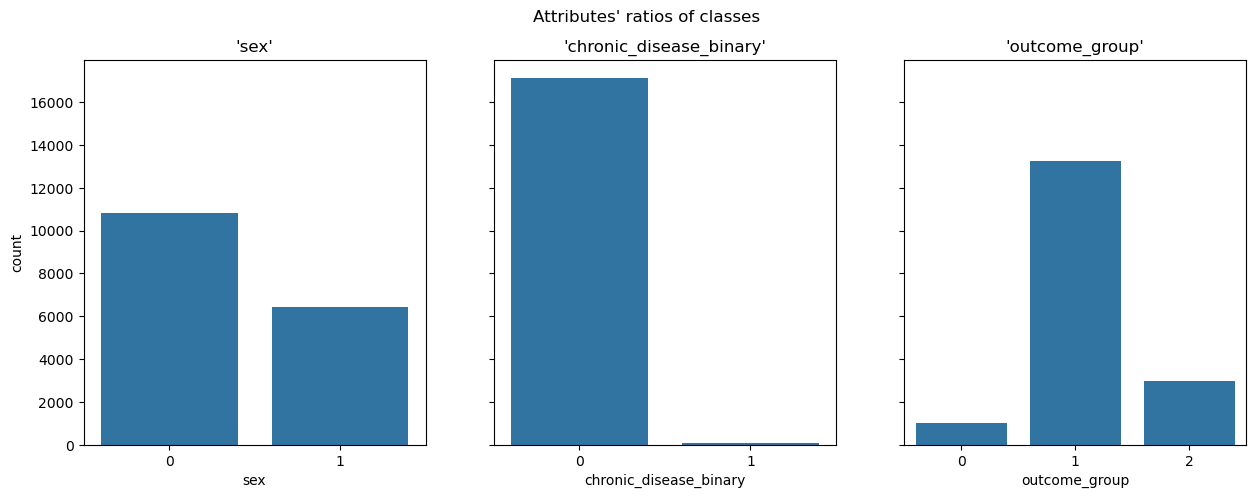

In [41]:
def plotClassDistributions(df):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
    # sns.barplot(ax=axes[0], x=trainData["sex"], y=trainData.index)
    sns.countplot(data=df, x='sex', ax=axes[0])
    axes[0].set_title("'sex'")
    # sns.barplot(ax=axes[1], x=trainData["chronic_disease_binary"], y=trainData.index)
    sns.countplot(data=df, x='chronic_disease_binary', ax=axes[1])
    axes[1].set_title("'chronic_disease_binary'")
    # sns.barplot(ax=axes[2], x=trainData["outcome_group"], y=trainData.index)
    sns.countplot(data=df, x='outcome_group', ax=axes[2])
    axes[2].set_title("'outcome_group'")
    fig.suptitle("Attributes' ratios of classes")
plotClassDistributions(trainData)

new data shape is  (21598, 15)


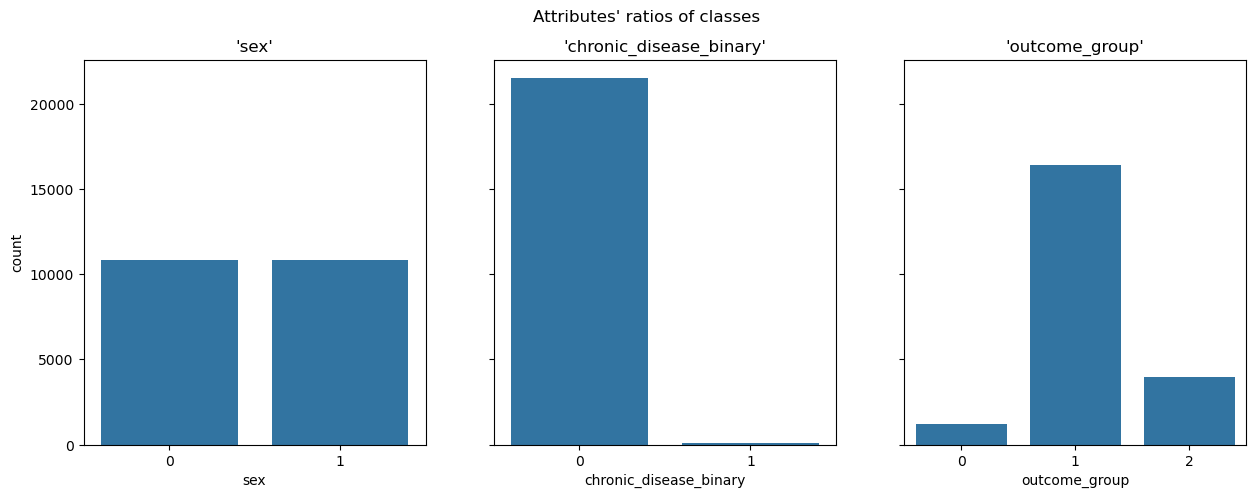

In [42]:
sm = SMOTENC(random_state=42, categorical_features=[1, 2, 3, 5, 6, 13])
newData, newSubData = sm.fit_resample(trainData.drop(columns=["sex"]), trainData["sex"])
newData["sex"] = newSubData
print("new data shape is ", newData.shape)
plotClassDistributions(newData)

new data shape is  (43020, 15)


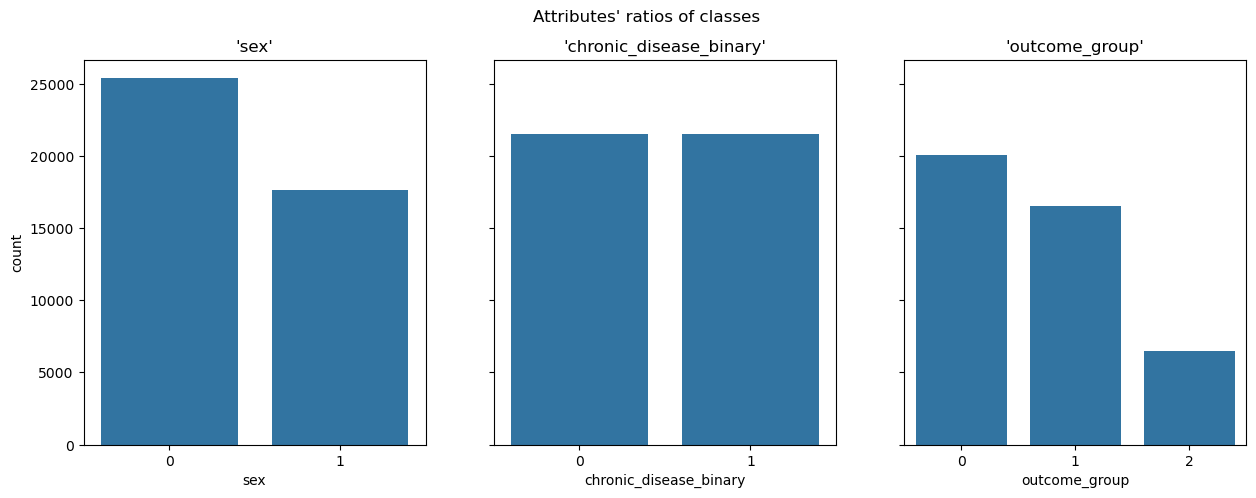

In [43]:
sm = SMOTENC(random_state=42, categorical_features=[1, 2, 5, 12, 13])
newData, newSubData = sm.fit_resample(newData.drop(columns=["chronic_disease_binary"]), newData["chronic_disease_binary"])
newData["chronic_disease_binary"] = newSubData
print("new data shape is ", newData.shape)
plotClassDistributions(newData)

new data shape is  (60084, 15)


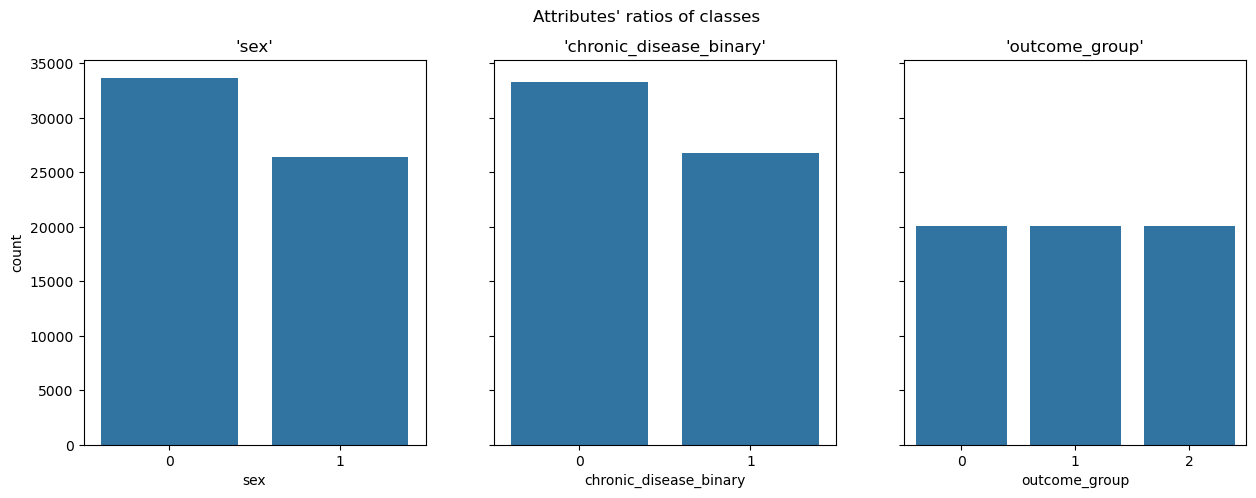

In [44]:
sm = SMOTENC(random_state=42, categorical_features=[1, 2, 5, 12, 13])
newData, newSubData = sm.fit_resample(newData.drop(columns=["outcome_group"]), newData["outcome_group"])
newData["outcome_group"] = newSubData
print("new data shape is ", newData.shape)
plotClassDistributions(newData)

In [49]:
ratiosClasses(newData)

(60084, 14)

column 'sex':
0: 33672 (56.04%)
1: 26412 (43.96%)

column 'outcome_group':
1: 20028 (33.33%)
2: 20028 (33.33%)
0: 20028 (33.33%)

column 'chronic_disease_binary':
0: 33308 (55.44%)
1: 26776 (44.56%)


KeyError: "['date_confirmation'] not in index"

In [ ]:
# TASK 6: NAIVE BAYES CLASSIFIER ON TRAIN SET
cols = list(trainData.columns.values)
newData = newData[cols]
# Load train set - replace Mapped_Train with balanced set
# data = pd.read_csv('dataset/Mapped_Train.csv')
# Drop date
data = newData.drop('date_confirmation',axis=1)
# newData = newData.drop('date_confirmation',axis=1)
X = data.drop('outcome_group', axis=1)
y = data['outcome_group']
# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Initialize gaussian naive bayes classifier
naive_bayes_classifier = GaussianNB()

# Train the classifier
naive_bayes_classifier.fit(X_train, y_train)

# Predictions on the testing set
y_pred = naive_bayes_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy of NB model:", accuracy)

# Report, enable to see details
# print(classification_report(y_test, y_pred))


       age  sex  province  country   latitude   longitude  \
0       18    1         0        0  25.490960   85.939030   
1       27    1         1        1   7.070000  125.600000   
2       46    0         2        0  13.083620   80.282520   
3       21    1         2        0  13.083620   80.282520   
4       27    0         0        0  26.283610   87.203470   
...    ...  ...       ...      ...        ...         ...   
60079   48    0         1        1  11.768406  122.802920   
60080   40    1         1        1  12.029136  122.727805   
60081   68    0         1        1  14.011211  121.006795   
60082   34    1         1        1  14.604261  121.068608   
60083   70    0         1        1  14.595632  121.029830   

       chronic_disease_binary  Confirmed  Deaths  Recovered  Active  \
0                           0     265527    1576     262371    1580   
1                           0     747288   13297     603746  130245   
2                           0     886673   12719     8

KeyError: "['date_confirmation'] not found in axis"